In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
from xgboost import plot_importance
import hopsworks
import json
from functions import util
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
with open('./hopsworks_API.txt', 'r') as file:
    os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()

In [3]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1171609
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)

In [5]:
air_quality = air_quality_fg.read()

air_quality['lag_1'] = air_quality['pm25'].shift(1)
air_quality['lag_2'] = air_quality['pm25'].shift(2)
air_quality['lag_3'] = air_quality['pm25'].shift(3)

air_quality['lagged_1to3days'] = air_quality[['lag_1', 'lag_2', 'lag_3']].apply(
    lambda x: ','.join(map(str, x)), axis=1
)

air_quality = air_quality.dropna()

air_quality[['date', 'pm25', 'lagged_1to3days']]

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 


,date,pm25,lagged_1to3days
3,2014-04-12 00:00:00+00:00,114.0,"75.0,91.0,47.0"
4,2018-10-29 00:00:00+00:00,85.0,"114.0,75.0,91.0"
5,2023-07-27 00:00:00+00:00,30.0,"85.0,114.0,75.0"
6,2020-03-24 00:00:00+00:00,98.0,"30.0,85.0,114.0"
7,2021-06-12 00:00:00+00:00,23.0,"98.0,30.0,85.0"
...,...,...,...
3937,2017-03-23 00:00:00+00:00,63.0,"70.0,31.0,59.0"
3938,2020-07-31 00:00:00+00:00,34.0,"63.0,70.0,31.0"
3939,2019-11-14 00:00:00+00:00,112.0,"34.0,63.0,70.0"
3940,2022-05-05 00:00:00+00:00,83.0,"112.0,34.0,63.0"


In [6]:
util.delete_feature_groups(fs, "air_quality_new")

Deleted air_quality_new/1


In [7]:
air_quality_new = fs.create_feature_group(
    name='air_quality_new',
    version=1,
    description="new feature group with new figure lagged 1-3 days data",
    primary_key=['date', 'city', 'street'],
    event_time="date")

In [8]:
air_quality_new.insert(
    air_quality[['date', 'pm25', 'country', 'city', 'street', 'url', 'lag_1','lag_2','lag_3']],
    write_options={"wait_for_job": True}
)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1171609/fs/1162312/fg/1357132


Uploading Dataframe: 0.00% |          | Rows 0/3939 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: air_quality_new_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1171609/jobs/named/air_quality_new_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x25b9b1a6350>, None)

In [9]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [12]:
# Select features for training data.
selected_features = air_quality_new.select(['pm25', 'lag_1', 'lag_2', 'lag_3']).join(weather_fg.select_all(), on=['city']) # 将pm25特征加入weather_fg生成新特征组
selected_features.show(10)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.54s) 


,pm25,lag_1,lag_2,lag_3,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,157.0,50.0,62.0,73.0,2014-01-01 00:00:00+00:00,12.381081,0.0,6.130579,110.833450,Meizhou
1,170.0,21.0,53.0,87.0,2014-01-02 00:00:00+00:00,15.585250,0.0,6.193674,124.484024,Meizhou
2,169.0,124.0,61.0,147.0,2014-01-03 00:00:00+00:00,15.187329,0.0,10.002560,336.879120,Meizhou
3,168.0,140.0,63.0,122.0,2014-01-04 00:00:00+00:00,11.337335,0.0,12.371645,353.517029,Meizhou
4,172.0,85.0,49.0,158.0,2014-01-05 00:00:00+00:00,11.814416,0.0,8.209263,94.712585,Meizhou
5,194.0,50.0,69.0,101.0,2014-01-06 00:00:00+00:00,13.312335,0.0,9.449572,110.497421,Meizhou
6,167.0,81.0,75.0,84.0,2014-01-07 00:00:00+00:00,16.772749,0.4,10.137691,174.696701,Meizhou
7,155.0,93.0,78.0,61.0,2014-01-08 00:00:00+00:00,12.503999,1.2,16.595179,349.205231,Meizhou
8,107.0,22.0,68.0,40.0,2014-01-09 00:00:00+00:00,11.701917,0.1,9.346143,12.299344,Meizhou
9,137.0,57.0,53.0,104.0,2014-01-10 00:00:00+00:00,11.639417,0.0,6.409617,59.524239,Meizhou


In [13]:
feature_view_new = fs.create_feature_view(
    name='air_quality_view',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1171609/fs/1162312/fv/air_quality_view/version/1


In [14]:
feature_view_new.schema

[Training Dataset Feature('pm25', 'float', 0, True, None, pm25, 1357132),
 Training Dataset Feature('lag_1', 'float', 1, False, None, lag_1, 1357132),
 Training Dataset Feature('lag_2', 'float', 2, False, None, lag_2, 1357132),
 Training Dataset Feature('lag_3', 'float', 3, False, None, lag_3, 1357132),
 Training Dataset Feature('date', 'timestamp', 4, False, None, date, 1348993),
 Training Dataset Feature('temperature_2m_mean', 'float', 5, False, None, temperature_2m_mean, 1348993),
 Training Dataset Feature('precipitation_sum', 'float', 6, False, None, precipitation_sum, 1348993),
 Training Dataset Feature('wind_speed_10m_max', 'float', 7, False, None, wind_speed_10m_max, 1348993),
 Training Dataset Feature('wind_direction_10m_dominant', 'float', 8, False, None, wind_direction_10m_dominant, 1348993),
 Training Dataset Feature('city', 'string', 9, False, None, city, 1348993)]

In [15]:
start_date_test_data = "2024-10-15"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [16]:
X_train, X_test, y_train, y_test = feature_view_new.train_test_split(
    # test_start=test_start
    test_size = 0.2
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.42s) 


In [17]:
X_train

,lag_1,lag_2,lag_3,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,50.0,62.0,73.0,2014-01-01 00:00:00+00:00,12.381081,0.0,6.130579,110.833450,Meizhou
1,21.0,53.0,87.0,2014-01-02 00:00:00+00:00,15.585250,0.0,6.193674,124.484024,Meizhou
2,124.0,61.0,147.0,2014-01-03 00:00:00+00:00,15.187329,0.0,10.002560,336.879120,Meizhou
4,85.0,49.0,158.0,2014-01-05 00:00:00+00:00,11.814416,0.0,8.209263,94.712585,Meizhou
6,81.0,75.0,84.0,2014-01-07 00:00:00+00:00,16.772749,0.4,10.137691,174.696701,Meizhou
...,...,...,...,...,...,...,...,...,...
3934,56.0,40.0,52.0,2024-11-12 00:00:00+00:00,25.458998,0.0,10.182337,38.583073,Meizhou
3935,139.0,147.0,116.0,2024-11-13 00:00:00+00:00,25.398581,0.3,14.529915,45.245213,Meizhou
3936,107.0,115.0,78.0,2024-11-13 00:00:00+00:00,25.398581,0.3,14.529915,45.245213,Meizhou
3937,93.0,65.0,125.0,2024-11-13 00:00:00+00:00,25.398581,0.3,14.529915,45.245213,Meizhou


In [18]:
# Drop the index columns - 'date' (event_time) and 'city' (primary key)

train_features = X_train.drop(['date', 'city'], axis=1)
test_features = X_test.drop(['date', 'city'], axis=1)

In [19]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(train_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [21]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 718.5762
R squared: 0.33121478969990414


In [22]:
df = y_test
df['predicted_pm25'] = y_pred

In [23]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
3,168.0,68.422043,2014-01-04 00:00:00+00:00
5,194.0,136.910782,2014-01-06 00:00:00+00:00
9,137.0,135.202286,2014-01-10 00:00:00+00:00
10,149.0,149.484100,2014-01-11 00:00:00+00:00
21,131.0,83.491524,2014-01-22 00:00:00+00:00


In [24]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [25]:
secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.


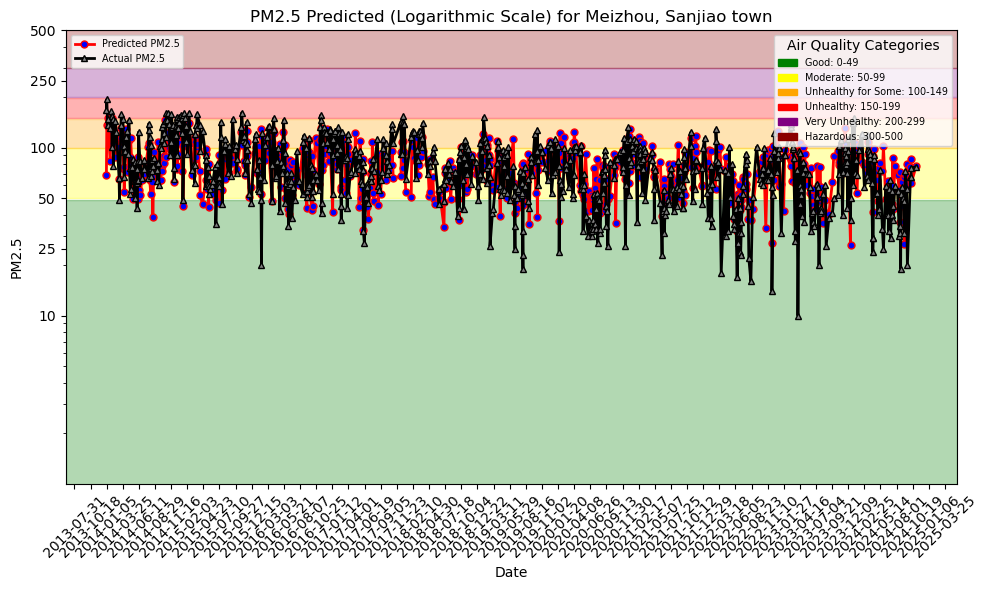

In [26]:
file_path = images_dir + "/pm25_hindcast_new.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

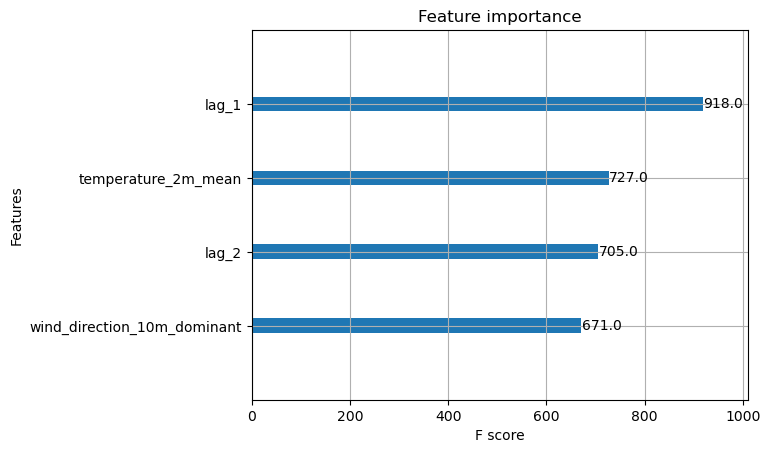

In [27]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor, max_num_features=4)  # plot重要性，可设置重要性指标
feature_importance_path = images_dir + "/feature_importance_new.png"
plt.savefig(feature_importance_path)
plt.show()

In [28]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

# Creating input and output schemas using the 'Schema' class for features (X) and target variable (y)
input_schema = Schema(X_train)
output_schema = Schema(y_train)

# Creating a model schema using 'ModelSchema' with the input and output schemas
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

# Converting the model schema to a dictionary representation
schema_dict = model_schema.to_dict()

In [29]:
xgb_regressor.save_model(model_dir + "/model_new.json")

In [30]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
}

In [31]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model_new", 
    metrics= res_dict,
    model_schema=model_schema,
    input_example=X_test.sample().values, 
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/541452 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/517504 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/19695 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/17648 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/151304 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/148280 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/136 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/898 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/1171609/models/air_quality_xgboost_model_new/2


Model(name: 'air_quality_xgboost_model_new', version: 2)